# **Import Libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# **Data Loading**

In [55]:
# Path to your dataset
dataset_path = Path("/content/drive/MyDrive/data_skeleton")
images_path = dataset_path / "ori"
masks_path = dataset_path / "skeleton"

## *Helper Function to Walk Through Directories*

In [56]:
# Function to walk through directories
def walk_through_dir(base_path):
    for dirpath, dirnames, filenames in os.walk(base_path):
        print(f'Found {len(filenames)} images in {dirpath}')
        break

# Walk through images and masks directories
walk_through_dir(images_path)
walk_through_dir(masks_path)

Found 256 images in /content/drive/MyDrive/data_skeleton/ori
Found 256 images in /content/drive/MyDrive/data_skeleton/skeleton


## *Helper Class for Data Loading*

In [57]:
class PoreSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            # Load image and mask
            image = Image.open(self.image_paths[idx]).convert("L")  # Grayscale
            mask = Image.open(self.mask_paths[idx]).convert("L")  # Grayscale
        except Exception as e:
            raise RuntimeError(f"Error loading image or mask: {e}")

        # Convert to tensors and normalize
        image = ToTensor()(image)  # Convert to Tensor and normalize to [0, 1]
        mask = ToTensor()(mask).float()  # Convert to Tensor and normalize to [0, 1]

        # Ensure binary masks
        mask = (mask > 0.5).float()  # Threshold to binary (0 or 1)

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# **Load and Transform Data**

In [58]:
import re

In [59]:
# Define a function to extract the numeric part of a filename
def extract_number(path):
    match = re.search(r'(\d+)', path.name)
    return int(match.group(1)) if match else float('inf')  # Handle cases with no number

# Sort paths numerically
image_paths = sorted(images_path.glob("*.png"), key=extract_number)
mask_paths = sorted(masks_path.glob("*.png"), key=extract_number)

In [64]:
# Split into train, validation, and test sets
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    train_image_paths, train_mask_paths, test_size=0.2, random_state=42
)

# Create datasets
train_dataset = PoreSegmentationDataset(train_image_paths, train_mask_paths)
val_dataset = PoreSegmentationDataset(val_image_paths, val_mask_paths)
test_dataset = PoreSegmentationDataset(test_image_paths, test_mask_paths)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [61]:
print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Training dataset size: 163
Validation dataset size: 41
Test dataset size: 52


## *Visualizing a Random Sample*

In [65]:
import torchvision.transforms as T
import random

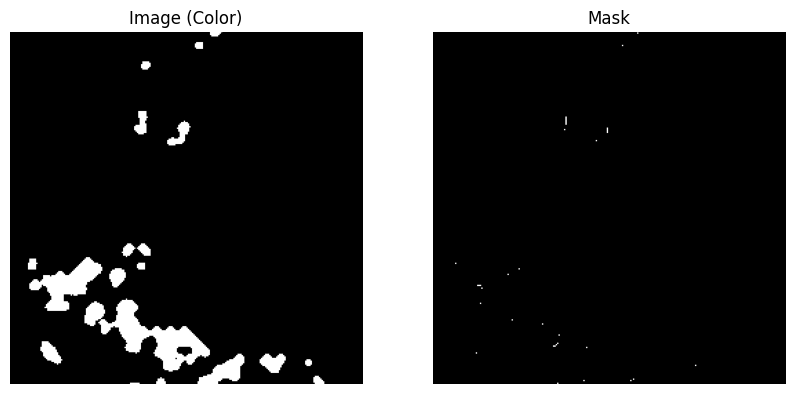

In [67]:
# Function to display a random image and its mask
def display_random_image_with_mask(dataset):
    # Randomly select an index
    idx = random.randint(0, len(dataset) - 1)

    # Get the image and mask
    image, mask = dataset[idx]

    # If tensors, convert to PIL for visualization
    if isinstance(image, torch.Tensor):
        image = T.ToPILImage()(image)
    if isinstance(mask, torch.Tensor):
        mask = T.ToPILImage()(mask)

    # Display the image and mask
    plt.figure(figsize=(10, 5))

    # Display image in color
    plt.subplot(1, 2, 1)
    plt.imshow(image,cmap="gray")  # Displays image in GrayScale
    plt.title("Image (Color)")
    plt.axis("off")

    # Display mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Mask")
    plt.axis("off")

    plt.show()

# Display random image with mask from training dataset
display_random_image_with_mask(train_dataset)

# **Model (UNet Architecture)**

In [68]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        self.upconv1 = self.upconv_block(512, 256)
        self.upconv2 = self.upconv_block(256, 128)
        self.upconv3 = self.upconv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

        self.upsample_to_input = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # Added Batch Normalization
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # Added Batch Normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),  # Added Batch Normalization
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)

        dec1 = self.upconv1(enc4)
        dec2 = self.upconv2(dec1 + enc3)
        dec3 = self.upconv3(dec2 + enc2)

        final = self.final(dec3 + enc1)

        if final.shape[-2:] != x.shape[-2:]:
            final = self.upsample_to_input(final)

        return final

# **Loss Functions**

In [72]:
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = torch.nn.functional.interpolate(pred, size=(256, 256), mode='bilinear', align_corners=True)
    pred = pred.view(pred.size(0), -1)
    target = target.view(target.size(0), -1)

    intersection = (pred * target).sum(dim=1)
    pred_sum = pred.sum(dim=1)
    target_sum = target.sum(dim=1)

    dice = (2. * intersection + smooth) / (pred_sum + target_sum + smooth)

    return 1 - dice.mean()

def iou_score(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()  # Thresholding
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

# **Model Training**

In [73]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(1, 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

In [74]:
history = {
    "train_loss": [],
    "val_loss": [],
    "iou_score": []
}

epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = dice_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    history["train_loss"].append(avg_train_loss)
    print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss}")

    model.eval()
    val_loss = 0.0
    iou = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            val_loss += dice_loss(outputs, masks).item()
            iou += iou_score(outputs, masks).item()

    avg_val_loss = val_loss / len(val_loader)
    avg_iou = iou / len(val_loader)
    history["val_loss"].append(avg_val_loss)
    history["iou_score"].append(avg_iou)
    print(f"Validation Loss: {avg_val_loss}, IoU Score: {avg_iou}")

Epoch 1/100: 100%|██████████| 11/11 [00:54<00:00,  4.91s/it]


Epoch 1: Train Loss: 0.9953744465654547
Validation Loss: 0.9963089028994242, IoU Score: 0.004393898105869691


Epoch 2/100: 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


Epoch 2: Train Loss: 0.993123238736933
Validation Loss: 0.9942095279693604, IoU Score: 0.005766924781103929


Epoch 3/100: 100%|██████████| 11/11 [00:03<00:00,  2.84it/s]


Epoch 3: Train Loss: 0.9916437268257141
Validation Loss: 0.9937199552853903, IoU Score: 0.007205470620344083


Epoch 4/100: 100%|██████████| 11/11 [00:03<00:00,  2.86it/s]


Epoch 4: Train Loss: 0.9897918538613752
Validation Loss: 0.989774207274119, IoU Score: 0.00824314650769035


Epoch 5/100: 100%|██████████| 11/11 [00:03<00:00,  2.93it/s]


Epoch 5: Train Loss: 0.9881154136224226
Validation Loss: 0.9943196177482605, IoU Score: 0.003749867513154944


Epoch 6/100: 100%|██████████| 11/11 [00:03<00:00,  2.92it/s]


Epoch 6: Train Loss: 0.9862211184068159
Validation Loss: 0.9844592014948527, IoU Score: 0.01010026348133882


Epoch 7/100: 100%|██████████| 11/11 [00:03<00:00,  2.84it/s]


Epoch 7: Train Loss: 0.983052058653398
Validation Loss: 0.9796471198399862, IoU Score: 0.013844644029935202


Epoch 8/100: 100%|██████████| 11/11 [00:03<00:00,  2.92it/s]


Epoch 8: Train Loss: 0.9741554910486395
Validation Loss: 0.9710966348648071, IoU Score: 0.020896288255850475


Epoch 9/100: 100%|██████████| 11/11 [00:03<00:00,  2.92it/s]


Epoch 9: Train Loss: 0.9581488912755792
Validation Loss: 0.9508866866429647, IoU Score: 0.03853474805752436


Epoch 10/100: 100%|██████████| 11/11 [00:03<00:00,  2.88it/s]


Epoch 10: Train Loss: 0.9410837888717651
Validation Loss: 0.9487230181694031, IoU Score: 0.0419036311407884


Epoch 11/100: 100%|██████████| 11/11 [00:03<00:00,  2.87it/s]


Epoch 11: Train Loss: 0.9246249849146063
Validation Loss: 0.9471640586853027, IoU Score: 0.030688345432281494


Epoch 12/100: 100%|██████████| 11/11 [00:03<00:00,  2.88it/s]


Epoch 12: Train Loss: 0.9124400073831732
Validation Loss: 0.9355201721191406, IoU Score: 0.03790287797649702


Epoch 13/100: 100%|██████████| 11/11 [00:03<00:00,  2.86it/s]


Epoch 13: Train Loss: 0.905254759571769
Validation Loss: 0.9410794973373413, IoU Score: 0.03338368237018585


Epoch 14/100: 100%|██████████| 11/11 [00:03<00:00,  2.85it/s]


Epoch 14: Train Loss: 0.8930648782036521
Validation Loss: 0.9263165990511576, IoU Score: 0.039878204464912415


Epoch 15/100: 100%|██████████| 11/11 [00:03<00:00,  2.87it/s]


Epoch 15: Train Loss: 0.8891340548341925
Validation Loss: 0.9260284701983134, IoU Score: 0.039780410627524056


Epoch 16/100: 100%|██████████| 11/11 [00:03<00:00,  2.85it/s]


Epoch 16: Train Loss: 0.8781424544074319
Validation Loss: 0.959032932917277, IoU Score: 0.017162948846817017


Epoch 17/100: 100%|██████████| 11/11 [00:03<00:00,  2.84it/s]


Epoch 17: Train Loss: 0.8724924705245278
Validation Loss: 0.9186352094014486, IoU Score: 0.04637785876790682


Epoch 18/100: 100%|██████████| 11/11 [00:03<00:00,  2.88it/s]


Epoch 18: Train Loss: 0.8696683807806536
Validation Loss: 0.9325670401255289, IoU Score: 0.032223294178644814


Epoch 19/100: 100%|██████████| 11/11 [00:03<00:00,  2.86it/s]


Epoch 19: Train Loss: 0.8667714649980719
Validation Loss: 0.9210434754689535, IoU Score: 0.043337675432364144


Epoch 20/100: 100%|██████████| 11/11 [00:03<00:00,  2.82it/s]


Epoch 20: Train Loss: 0.8570588664575056
Validation Loss: 0.9249906738599142, IoU Score: 0.03955507402618726


Epoch 21/100: 100%|██████████| 11/11 [00:03<00:00,  2.85it/s]


Epoch 21: Train Loss: 0.8526045246557756
Validation Loss: 0.9416651725769043, IoU Score: 0.0294780849168698


Epoch 22/100: 100%|██████████| 11/11 [00:03<00:00,  2.87it/s]


Epoch 22: Train Loss: 0.8376661268147555
Validation Loss: 0.9224669138590494, IoU Score: 0.041741554935773216


Epoch 23/100: 100%|██████████| 11/11 [00:03<00:00,  2.79it/s]


Epoch 23: Train Loss: 0.8472144766287371
Validation Loss: 0.9318855206171671, IoU Score: 0.0361782672504584


Epoch 24/100: 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


Epoch 24: Train Loss: 0.829376529563557
Validation Loss: 0.9203178882598877, IoU Score: 0.04283265024423599


Epoch 25/100: 100%|██████████| 11/11 [00:03<00:00,  2.85it/s]


Epoch 25: Train Loss: 0.8182360421527516
Validation Loss: 0.951932688554128, IoU Score: 0.023308124393224716


Epoch 26/100: 100%|██████████| 11/11 [00:03<00:00,  2.80it/s]


Epoch 26: Train Loss: 0.8352190581235018
Validation Loss: 0.917142391204834, IoU Score: 0.04523266355196635


Epoch 27/100: 100%|██████████| 11/11 [00:04<00:00,  2.50it/s]


Epoch 27: Train Loss: 0.8141118884086609
Validation Loss: 0.9188032746315002, IoU Score: 0.04352030158042908


Epoch 28/100: 100%|██████████| 11/11 [00:04<00:00,  2.31it/s]


Epoch 28: Train Loss: 0.7997424710880626
Validation Loss: 0.9190126657485962, IoU Score: 0.04315648848811785


Epoch 29/100: 100%|██████████| 11/11 [00:04<00:00,  2.21it/s]


Epoch 29: Train Loss: 0.8069607181982561
Validation Loss: 0.9346918861071268, IoU Score: 0.03470644478996595


Epoch 30/100: 100%|██████████| 11/11 [00:03<00:00,  2.84it/s]


Epoch 30: Train Loss: 0.8055212064222856
Validation Loss: 0.9154233336448669, IoU Score: 0.04433573161562284


Epoch 31/100: 100%|██████████| 11/11 [00:03<00:00,  2.79it/s]


Epoch 31: Train Loss: 0.7939257621765137
Validation Loss: 0.9202117323875427, IoU Score: 0.04275455822547277


Epoch 32/100: 100%|██████████| 11/11 [00:03<00:00,  2.76it/s]


Epoch 32: Train Loss: 0.7978410775011237
Validation Loss: 0.9170617858568827, IoU Score: 0.045643762995799385


Epoch 33/100: 100%|██████████| 11/11 [00:03<00:00,  2.82it/s]


Epoch 33: Train Loss: 0.7850290970368818
Validation Loss: 0.9179074168205261, IoU Score: 0.043889790773391724


Epoch 34/100: 100%|██████████| 11/11 [00:03<00:00,  2.81it/s]


Epoch 34: Train Loss: 0.7787642587314952
Validation Loss: 0.928927481174469, IoU Score: 0.04017453889052073


Epoch 35/100: 100%|██████████| 11/11 [00:03<00:00,  2.78it/s]


Epoch 35: Train Loss: 0.7757260203361511
Validation Loss: 0.9427195191383362, IoU Score: 0.03112017239133517


Epoch 36/100: 100%|██████████| 11/11 [00:03<00:00,  2.84it/s]


Epoch 36: Train Loss: 0.7732799432494424
Validation Loss: 0.9257402618726095, IoU Score: 0.041055288165807724


Epoch 37/100: 100%|██████████| 11/11 [00:03<00:00,  2.83it/s]


Epoch 37: Train Loss: 0.7572258710861206
Validation Loss: 0.9146421353022257, IoU Score: 0.046264449755350746


Epoch 38/100: 100%|██████████| 11/11 [00:03<00:00,  2.77it/s]


Epoch 38: Train Loss: 0.7584470076994463
Validation Loss: 0.9301707744598389, IoU Score: 0.03939096381266912


Epoch 39/100: 100%|██████████| 11/11 [00:03<00:00,  2.85it/s]


Epoch 39: Train Loss: 0.7457488233392889
Validation Loss: 0.9268369873364767, IoU Score: 0.039530555407206215


Epoch 40/100: 100%|██████████| 11/11 [00:03<00:00,  2.86it/s]


Epoch 40: Train Loss: 0.7374875112013384
Validation Loss: 0.9256557623545328, IoU Score: 0.042520382752021156


Epoch 41/100: 100%|██████████| 11/11 [00:03<00:00,  2.78it/s]


Epoch 41: Train Loss: 0.734604374928908
Validation Loss: 0.9467917680740356, IoU Score: 0.02696493702630202


Epoch 42/100: 100%|██████████| 11/11 [00:03<00:00,  2.85it/s]


Epoch 42: Train Loss: 0.7352132363752886
Validation Loss: 0.9160369833310446, IoU Score: 0.04570197065671285


Epoch 43/100: 100%|██████████| 11/11 [00:03<00:00,  2.84it/s]


Epoch 43: Train Loss: 0.7373778169805353
Validation Loss: 0.9314119617144266, IoU Score: 0.03464890147248904


Epoch 44/100: 100%|██████████| 11/11 [00:03<00:00,  2.75it/s]


Epoch 44: Train Loss: 0.7244695370847528
Validation Loss: 0.9199248949686686, IoU Score: 0.04323427130778631


Epoch 45/100: 100%|██████████| 11/11 [00:03<00:00,  2.83it/s]


Epoch 45: Train Loss: 0.7223443659869108
Validation Loss: 0.9442167083422343, IoU Score: 0.02893207346399625


Epoch 46/100: 100%|██████████| 11/11 [00:03<00:00,  2.82it/s]


Epoch 46: Train Loss: 0.702426552772522
Validation Loss: 0.9297181963920593, IoU Score: 0.036853437622388206


Epoch 47/100: 100%|██████████| 11/11 [00:03<00:00,  2.78it/s]


Epoch 47: Train Loss: 0.7136490019884977
Validation Loss: 0.9213202397028605, IoU Score: 0.0419970378279686


Epoch 48/100: 100%|██████████| 11/11 [00:03<00:00,  2.84it/s]


Epoch 48: Train Loss: 0.7314666130326011
Validation Loss: 0.9208489060401917, IoU Score: 0.041402045637369156


Epoch 49/100: 100%|██████████| 11/11 [00:03<00:00,  2.80it/s]


Epoch 49: Train Loss: 0.7254556959325617
Validation Loss: 0.9582538604736328, IoU Score: 0.020962629467248917


Epoch 50/100: 100%|██████████| 11/11 [00:03<00:00,  2.77it/s]


Epoch 50: Train Loss: 0.7210992574691772
Validation Loss: 0.929154614607493, IoU Score: 0.03682926173011462


Epoch 51/100: 100%|██████████| 11/11 [00:03<00:00,  2.80it/s]


Epoch 51: Train Loss: 0.7150855552066456
Validation Loss: 0.9409305651982626, IoU Score: 0.0314145398636659


Epoch 52/100: 100%|██████████| 11/11 [00:03<00:00,  2.82it/s]


Epoch 52: Train Loss: 0.7059380845590071
Validation Loss: 0.9310185710589091, IoU Score: 0.03447094435493151


Epoch 53/100: 100%|██████████| 11/11 [00:03<00:00,  2.77it/s]


Epoch 53: Train Loss: 0.7027720538052645
Validation Loss: 0.952214777469635, IoU Score: 0.022728934263189633


Epoch 54/100: 100%|██████████| 11/11 [00:03<00:00,  2.80it/s]


Epoch 54: Train Loss: 0.6925672130151228
Validation Loss: 0.9319271047910055, IoU Score: 0.036204113314549126


Epoch 55/100: 100%|██████████| 11/11 [00:03<00:00,  2.81it/s]


Epoch 55: Train Loss: 0.6879012855616483
Validation Loss: 0.926823616027832, IoU Score: 0.03954045350352923


Epoch 56/100: 100%|██████████| 11/11 [00:03<00:00,  2.77it/s]


Epoch 56: Train Loss: 0.6796859719536521
Validation Loss: 0.9328875343004862, IoU Score: 0.03490846728285154


Epoch 57/100: 100%|██████████| 11/11 [00:03<00:00,  2.82it/s]


Epoch 57: Train Loss: 0.6775335452773354
Validation Loss: 0.9406576752662659, IoU Score: 0.03198120494683584


Epoch 58/100: 100%|██████████| 11/11 [00:03<00:00,  2.84it/s]


Epoch 58: Train Loss: 0.6777494224635038
Validation Loss: 0.9443830053011576, IoU Score: 0.028944979111353557


Epoch 59/100: 100%|██████████| 11/11 [00:03<00:00,  2.80it/s]


Epoch 59: Train Loss: 0.6633965752341531
Validation Loss: 0.930488129456838, IoU Score: 0.03737563267350197


Epoch 60/100: 100%|██████████| 11/11 [00:03<00:00,  2.82it/s]


Epoch 60: Train Loss: 0.6849820993163369
Validation Loss: 0.9339637160301208, IoU Score: 0.034700160225232445


Epoch 61/100: 100%|██████████| 11/11 [00:03<00:00,  2.83it/s]


Epoch 61: Train Loss: 0.6630968126383695
Validation Loss: 0.939328114191691, IoU Score: 0.03198268202443918


Epoch 62/100: 100%|██████████| 11/11 [00:03<00:00,  2.81it/s]


Epoch 62: Train Loss: 0.6806893077763644
Validation Loss: 0.9324834942817688, IoU Score: 0.03566863760352135


Epoch 63/100: 100%|██████████| 11/11 [00:03<00:00,  2.79it/s]


Epoch 63: Train Loss: 0.6739826039834456
Validation Loss: 0.9424371918042501, IoU Score: 0.030191245178381603


Epoch 64/100: 100%|██████████| 11/11 [00:03<00:00,  2.83it/s]


Epoch 64: Train Loss: 0.6628819649869745
Validation Loss: 0.935685416062673, IoU Score: 0.033996821070710816


Epoch 65/100: 100%|██████████| 11/11 [00:03<00:00,  2.80it/s]


Epoch 65: Train Loss: 0.6632098934867166
Validation Loss: 0.9320688645044962, IoU Score: 0.03585569808880488


Epoch 66/100: 100%|██████████| 11/11 [00:03<00:00,  2.75it/s]


Epoch 66: Train Loss: 0.6486718437888406
Validation Loss: 0.9307921131451925, IoU Score: 0.03664294506112734


Epoch 67/100: 100%|██████████| 11/11 [00:03<00:00,  2.83it/s]


Epoch 67: Train Loss: 0.667224564335563
Validation Loss: 0.9266548554102579, IoU Score: 0.03811559205253919


Epoch 68/100: 100%|██████████| 11/11 [00:03<00:00,  2.83it/s]


Epoch 68: Train Loss: 0.6697551228783347
Validation Loss: 0.9273110032081604, IoU Score: 0.03841406603654226


Epoch 69/100: 100%|██████████| 11/11 [00:03<00:00,  2.77it/s]


Epoch 69: Train Loss: 0.6632834456183694
Validation Loss: 0.9411032994588217, IoU Score: 0.03058917137483756


Epoch 70/100: 100%|██████████| 11/11 [00:03<00:00,  2.82it/s]


Epoch 70: Train Loss: 0.6595783558758822
Validation Loss: 0.9358739058176676, IoU Score: 0.034008583053946495


Epoch 71/100: 100%|██████████| 11/11 [00:03<00:00,  2.83it/s]


Epoch 71: Train Loss: 0.6560955372723666
Validation Loss: 0.9302406311035156, IoU Score: 0.03681422770023346


Epoch 72/100: 100%|██████████| 11/11 [00:03<00:00,  2.78it/s]


Epoch 72: Train Loss: 0.6645855578509244
Validation Loss: 0.9344049692153931, IoU Score: 0.03429171380897363


Epoch 73/100: 100%|██████████| 11/11 [00:03<00:00,  2.81it/s]


Epoch 73: Train Loss: 0.645542486147447
Validation Loss: 0.9358262817064921, IoU Score: 0.03519561390082041


Epoch 74/100: 100%|██████████| 11/11 [00:03<00:00,  2.82it/s]


Epoch 74: Train Loss: 0.6500600738958879
Validation Loss: 0.9391987522443136, IoU Score: 0.031625282019376755


Epoch 75/100: 100%|██████████| 11/11 [00:04<00:00,  2.73it/s]


Epoch 75: Train Loss: 0.6644727262583646
Validation Loss: 0.9462313055992126, IoU Score: 0.028044415016969044


Epoch 76/100: 100%|██████████| 11/11 [00:03<00:00,  2.83it/s]


Epoch 76: Train Loss: 0.6499991904605519
Validation Loss: 0.9319989283879598, IoU Score: 0.03593485429883003


Epoch 77/100: 100%|██████████| 11/11 [00:03<00:00,  2.84it/s]


Epoch 77: Train Loss: 0.6525731574405323
Validation Loss: 0.9322221477826437, IoU Score: 0.03655290355285009


Epoch 78/100: 100%|██████████| 11/11 [00:04<00:00,  2.72it/s]


Epoch 78: Train Loss: 0.6488627737218683
Validation Loss: 0.9386579195658366, IoU Score: 0.033327860136826835


Epoch 79/100: 100%|██████████| 11/11 [00:03<00:00,  2.85it/s]


Epoch 79: Train Loss: 0.652719730680639
Validation Loss: 0.9352783958117167, IoU Score: 0.03448240955670675


Epoch 80/100: 100%|██████████| 11/11 [00:03<00:00,  2.84it/s]


Epoch 80: Train Loss: 0.6270044662735679
Validation Loss: 0.939976970354716, IoU Score: 0.03177827596664429


Epoch 81/100: 100%|██████████| 11/11 [00:04<00:00,  2.75it/s]


Epoch 81: Train Loss: 0.6659898649562489
Validation Loss: 0.9254635373751322, IoU Score: 0.03775083273649216


Epoch 82/100: 100%|██████████| 11/11 [00:03<00:00,  2.84it/s]


Epoch 82: Train Loss: 0.6625785448334434
Validation Loss: 0.9340039094289144, IoU Score: 0.03393763614197572


Epoch 83/100: 100%|██████████| 11/11 [00:03<00:00,  2.84it/s]


Epoch 83: Train Loss: 0.6749348532069813
Validation Loss: 0.9272998174031576, IoU Score: 0.03902928406993548


Epoch 84/100: 100%|██████████| 11/11 [00:03<00:00,  2.77it/s]


Epoch 84: Train Loss: 0.6689342314546759
Validation Loss: 0.9455588658650717, IoU Score: 0.028999969363212585


Epoch 85/100: 100%|██████████| 11/11 [00:03<00:00,  2.83it/s]


Epoch 85: Train Loss: 0.6489801190116189
Validation Loss: 0.9284237623214722, IoU Score: 0.03899902602036794


Epoch 86/100: 100%|██████████| 11/11 [00:03<00:00,  2.83it/s]


Epoch 86: Train Loss: 0.6551370133053173
Validation Loss: 0.931093434492747, IoU Score: 0.035267096012830734


Epoch 87/100: 100%|██████████| 11/11 [00:03<00:00,  2.76it/s]


Epoch 87: Train Loss: 0.646461849862879
Validation Loss: 0.941305677096049, IoU Score: 0.03108748917778333


Epoch 88/100: 100%|██████████| 11/11 [00:03<00:00,  2.83it/s]


Epoch 88: Train Loss: 0.6373781074177135
Validation Loss: 0.9372741977373759, IoU Score: 0.033169919004042946


Epoch 89/100: 100%|██████████| 11/11 [00:03<00:00,  2.83it/s]


Epoch 89: Train Loss: 0.6408575123006647
Validation Loss: 0.9491691191991171, IoU Score: 0.024794029692808788


Epoch 90/100: 100%|██████████| 11/11 [00:03<00:00,  2.78it/s]


Epoch 90: Train Loss: 0.6488634293729608
Validation Loss: 0.9409777720769247, IoU Score: 0.03157621497909228


Epoch 91/100: 100%|██████████| 11/11 [00:03<00:00,  2.82it/s]


Epoch 91: Train Loss: 0.6264021992683411
Validation Loss: 0.9375835061073303, IoU Score: 0.03292877537508806


Epoch 92/100: 100%|██████████| 11/11 [00:03<00:00,  2.83it/s]


Epoch 92: Train Loss: 0.627264835617759
Validation Loss: 0.9337447881698608, IoU Score: 0.03466080750028292


Epoch 93/100: 100%|██████████| 11/11 [00:03<00:00,  2.78it/s]


Epoch 93: Train Loss: 0.6326355717398904
Validation Loss: 0.9446519414583842, IoU Score: 0.02939820537964503


Epoch 94/100: 100%|██████████| 11/11 [00:03<00:00,  2.80it/s]


Epoch 94: Train Loss: 0.6327740008180792
Validation Loss: 0.9365645249684652, IoU Score: 0.03291588773330053


Epoch 95/100: 100%|██████████| 11/11 [00:03<00:00,  2.84it/s]


Epoch 95: Train Loss: 0.6236818432807922
Validation Loss: 0.9361687103907267, IoU Score: 0.033454405143857


Epoch 96/100: 100%|██████████| 11/11 [00:03<00:00,  2.81it/s]


Epoch 96: Train Loss: 0.6294091289693658
Validation Loss: 0.9372572302818298, IoU Score: 0.0335311945527792


Epoch 97/100: 100%|██████████| 11/11 [00:03<00:00,  2.79it/s]


Epoch 97: Train Loss: 0.6205639676614241
Validation Loss: 0.9445943037668864, IoU Score: 0.029067634294430416


Epoch 98/100: 100%|██████████| 11/11 [00:03<00:00,  2.84it/s]


Epoch 98: Train Loss: 0.6177327199415727
Validation Loss: 0.9381504058837891, IoU Score: 0.03249629524846872


Epoch 99/100: 100%|██████████| 11/11 [00:03<00:00,  2.80it/s]


Epoch 99: Train Loss: 0.6288639903068542
Validation Loss: 0.9365636507670084, IoU Score: 0.032063037157058716


Epoch 100/100: 100%|██████████| 11/11 [00:03<00:00,  2.80it/s]


Epoch 100: Train Loss: 0.6217819994146173
Validation Loss: 0.9397174517313639, IoU Score: 0.032698146998882294


## *Save the Model & Training History*

In [ ]:
# Define the model save path
model_save_dir = "/content/drive/MyDrive/pores_dataset/Trained Model"
os.makedirs(model_save_dir, exist_ok=True)

# Save the model
def save_model(model, model_save_dir):
    model_path = os.path.join(model_save_dir, "model.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model saved at {model_path}")

# Call the function to save the model
save_model(model, model_save_dir)

Model saved at /content/drive/MyDrive/pores_dataset/Trained Model/model.pth


In [ ]:
import pickle

# Save the training history (as a pickle file)
history_path = os.path.join(model_save_dir, "history.pkl")
with open(history_path, 'wb') as history_file:
    pickle.dump(history, history_file)
print(f"History saved at {history_path}")

History saved at /content/drive/MyDrive/pores_dataset/Trained Model/history.pkl


## *Load the Model & Training History*

In [ ]:
# Define the model instance
model = UNet(in_channels=1, out_channels=1)  # Example for input RGB images and binary segmentation output
model.load_state_dict(torch.load("/content/drive/MyDrive/pores_dataset/Trained Model/model.pth"))

# If using GPU, move the model to the correct device (e.g., CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
# Load the history
with open(os.path.join("/content/drive/MyDrive/pores_dataset/Trained Model", "history.pkl"), 'rb') as history_file:
    history = pickle.load(history_file)

print("Model and history loaded successfully!")

## *Visualize the Training History*

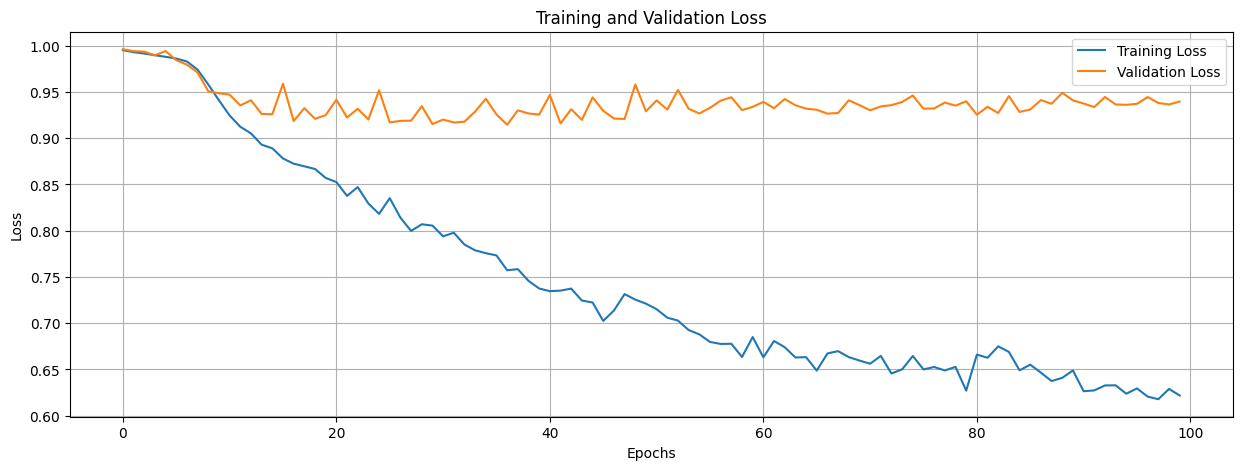

In [75]:
# Plot training and validation loss
plt.figure(figsize=(15, 5))
plt.plot(history["train_loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

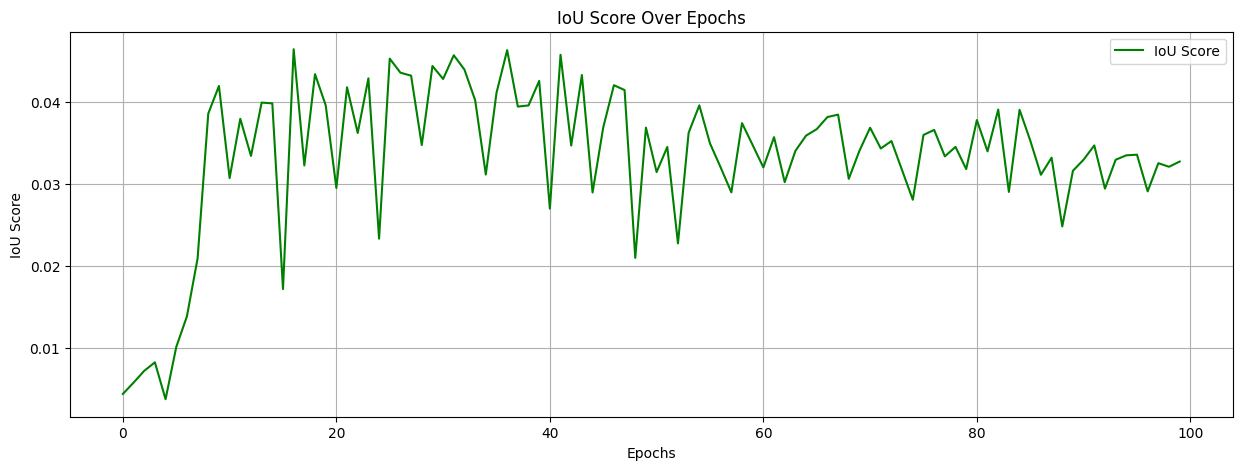

In [76]:
# Plot IoU score
plt.figure(figsize=(15, 5))
plt.plot(history["iou_score"], label="IoU Score", color="green")
plt.xlabel("Epochs")
plt.ylabel("IoU Score")
plt.title("IoU Score Over Epochs")
plt.legend()
plt.grid()
plt.show()

# **Evaluate the Model**

## *Validation and Testing*

In [ ]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
def dice_coefficient(pred, target):
    pred = pred.flatten()
    target = target.flatten()
    intersection = (pred * target).sum()
    return (2. * intersection) / (pred.sum() + target.sum() + 1e-8)

def iou(pred, target):
    pred = pred.flatten()
    target = target.flatten()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return intersection / (union + 1e-8)

# Evaluate model on test dataset
def evaluate_model(model, dataloader, threshold=0.5):
    model.eval()
    dice_scores, iou_scores, precisions, recalls, f1s = [], [], [], [], []

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (outputs.sigmoid() > threshold).float()

            for pred, mask in zip(preds, masks):
                dice_scores.append(dice_coefficient(pred.cpu().numpy(), mask.cpu().numpy()))
                iou_scores.append(iou(pred.cpu().numpy(), mask.cpu().numpy()))
                precisions.append(precision_score(mask.cpu().numpy().flatten(), pred.cpu().numpy().flatten()))
                recalls.append(recall_score(mask.cpu().numpy().flatten(), pred.cpu().numpy().flatten()))
                f1s.append(f1_score(mask.cpu().numpy().flatten(), pred.cpu().numpy().flatten()))

    print(f"Dice Coefficient: {np.mean(dice_scores):.4f}")
    print(f"IoU: {np.mean(iou_scores):.4f}")
    print(f"Precision: {np.mean(precisions):.4f}")
    print(f"Recall: {np.mean(recalls):.4f}")
    print(f"F1 Score: {np.mean(f1s):.4f}")

In [ ]:
evaluate_model(model, test_loader)

Dice Coefficient: 0.9739
IoU: 0.9492
Precision: 0.9710
Recall: 0.9770
F1 Score: 0.9739


## *Error Analysis*

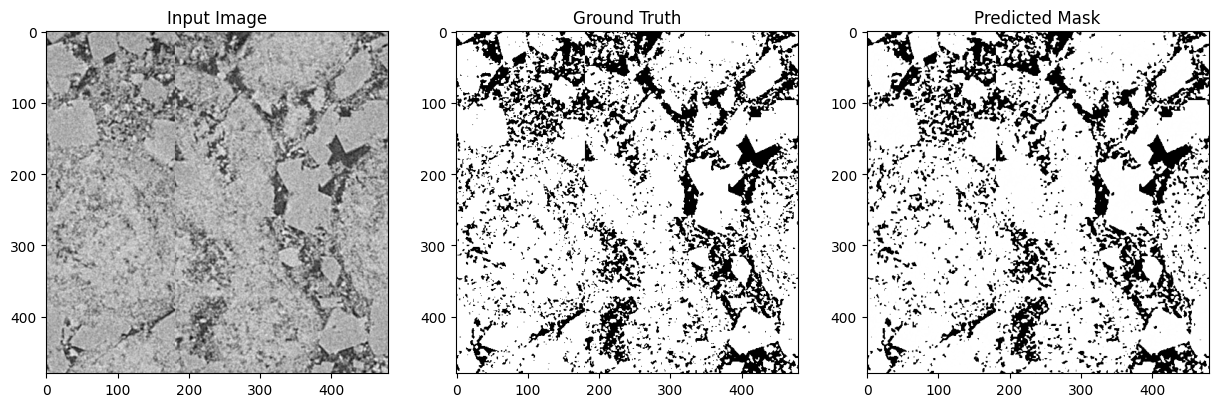

In [ ]:
# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    for images, masks in test_loader:
        # Move images and masks to the device
        images, masks = images.to(device), masks.to(device)

        # Get the model outputs
        outputs = model(images)
        outputs = torch.sigmoid(outputs).cpu().numpy()  # Apply sigmoid and move to CPU
        outputs = (outputs * 255).astype(np.uint8)  # Scale to [0, 255] for visualization

        images = images.cpu().numpy()
        masks = masks.cpu().numpy()

        # Visualize the input image, ground truth, and predicted mask
        fig, axes = plt.subplots(1, 3, figsize=(15, 6))

        # Input image (grayscale)
        axes[0].imshow(images[0, 0], cmap='gray')
        axes[0].set_title("Input Image")

        # Ground truth mask (binary, scaled to [0, 255] for visualization)
        axes[1].imshow(masks[0, 0], cmap='gray')
        axes[1].set_title("Ground Truth")

        # Predicted mask (scaled to [0, 255])
        axes[2].imshow(outputs[0, 0], cmap='gray')
        axes[2].set_title("Predicted Mask")

        # Display the visualization
        plt.show()

        break

# **Interpret Results**